# Week 13 Problem Set attempt
Ethan Marx, Haochen Wang, Geoffrey Mo
8.942 Fall 2020
Commit: https://github.com/EthanMarx/cmb-map-making/commit/1766d0bfa895f725cf5f7522d0669de2177ce820

In [50]:
import cmb_utils
import numpy as np
import pyfftw
import pyfftw.interfaces.numpy_fft as fft
from scipy.interpolate import interp1d
from scipy import linalg as LA
from scipy.integrate import trapz, quad
from scipy.special import jv
import matplotlib.pyplot as plt

import camb
import fiducial_parameters as fp
import importlib

In [2]:
pix_width = 0.0015707 # radians
cmb_data = np.load('cmb_analysis_pset_data.npz')

In [3]:
for key in cmb_data.keys():
    print(key)

test_signal
test_white_noise
test_red_noise
test_x
test_y
data_small
x_small
y_small
data_large
x_large
y_large


In [4]:
cmb_data['test_red_noise'].shape

(65536,)

# 1. Map making

## 1.1 Operators

All steps in this section are already provided in the starter code (cmb_utils). Section 1.1 in the pset is rather an explanation for what the starter code (more speficially the NoisePointingModel class) does.

## 1.2 Estimating the time stream noise power spectrum

First, we choose a data set to be processed.

In [5]:
dt_test = cmb_data['test_signal'] + cmb_data['test_white_noise'] + cmb_data['test_red_noise'] # test data
x_test = np.round(cmb_data['test_x']/pix_width).astype(int) # x coordinates of the test data, starting with 0
y_test = np.round(cmb_data['test_y']/pix_width).astype(int) # y coordinates of the test data, starting with 0
nx_test = np.amax(x_test) + 1 # Map size in x direction (plus 1 counting the 0th index) 
ny_test = np.amax(y_test) + 1 # Map size in y direction (plus 1 counting the 0th index)
nt_test = len(x_test) # total number of data points

In [6]:
print(nx_test, ny_test, nt_test)

32 32 65536


1. FFT $d_t$ and divide by $\sqrt{n_t}$ to obtain $d_\omega$.

In [7]:
dt = dt_test
x = x_test
y = y_test
nx = nx_test
ny = ny_test
nt = nt_test

In [8]:
d_omega = fft.rfft(dt)/np.sqrt(nt) # fft with real data as input
omega = fft.rfftfreq(nt)*2*np.pi # angular frequencies

2. The quantity $d_\omega d_\omega^*$ is then a noisy estimate for $P_\eta(\omega)$.

In [9]:
P_eta_unbinned = d_omega*np.conjugate(d_omega)

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

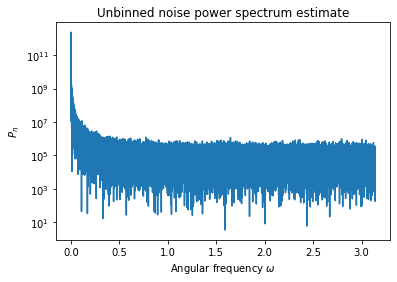

In [10]:
plt.plot(omega[:], P_eta_unbinned[:])
plt.title("Unbinned noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

3. Accumulate the estimate over bins in $\omega$ to reduce uncertainty

In [11]:
n_omega = len(omega) # number of frequencies
bins = np.linspace(omega[0], omega[-1], num = int(n_omega/100), endpoint = True) # bin edges, each bin contains about 100 points
P_eta_binned = np.histogram(omega, bins, weights=P_eta_unbinned)[0]/np.histogram(omega, bins)[0]
bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins) -1)])

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

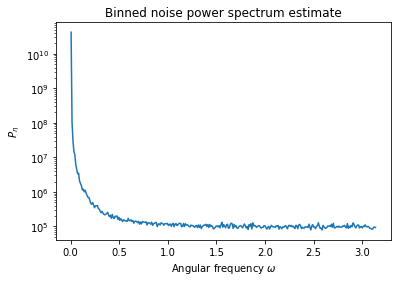

In [12]:
plt.plot(bin_centers[:], P_eta_binned[:])
plt.title("Binned noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

4. Interpolate/extrapolate the result to any $\omega$.

In [13]:
# Before we interpolate, we have to add the first and last data point. Otherwise interpolator will return "out of range"
first = np.sum(P_eta_unbinned[0:20])/20 # estimate for P_eta at omega[0], 20 is arbitrarily chosen
last = np.sum(P_eta_unbinned[-20:])/20 # estimate for P_eta at omega[-1]
omega_for_interp = np.insert(np.append(bin_centers, omega[-1]), 0, omega[0])
P_eta_for_interp = np.insert(np.append(P_eta_binned, last), 0, first)

In [14]:
P_eta_interp = interp1d(omega_for_interp, P_eta_for_interp)
P_eta_final = P_eta_interp(omega) # use interpolator to get P_eta at orignial omegas but now it is much smoother

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

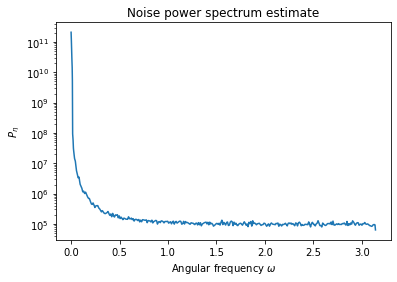

In [15]:
plt.plot(omega, P_eta_final)
plt.title("Noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

## 1.3 Noise covariance inverse

Obtain $C_N^{-1}$

In [16]:
model_test = cmb_utils.NoisePointingModel(x_test, y_test, nx_test, ny_test, P_eta_final)
CN_inv_test = model_test.map_noise_inv()
CN_inv_test.shape

(32, 32, 32, 32)

Reshape $C_N^{-1}$ into a 2D matrix.

In [17]:
CN_inv_test_reshape = np.reshape(CN_inv_test, (nx*ny, nx*ny))
CN_inv_test_reshape.shape

(1024, 1024)

Invert to obtain $C_N$.

In [18]:
CN_test = LA.inv(CN_inv_test_reshape)

Text(0.5, 1.0, '$C_N^{-1}*C_N$')

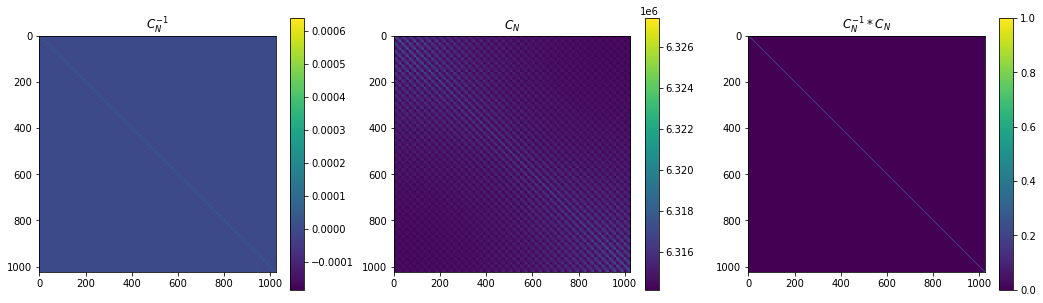

In [19]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(CN_inv_test_reshape)
plt.colorbar()
plt.title(r'$C_N^{-1}$')
plt.subplot(132)
plt.imshow(CN_test)
plt.colorbar()
plt.title(r'$C_N$')
plt.subplot(133)
plt.imshow(np.dot(CN_test,CN_inv_test_reshape))
plt.colorbar()
plt.title(r'$C_N^{-1}*C_N$')

Get the signal estimate with D&S (14.30)

In [29]:
N_inv_d_test = model_test.apply_noise_weights(dt)
out = np.zeros((nx, ny), dtype=float)
P_T_N_inv_d_test = model_test.grid_data(N_inv_d_test, out)

In [30]:
P_T_N_inv_d_test.shape

(32, 32)

In [31]:
s_hat_test = np.dot(CN_test, P_T_N_inv_d_test.flatten())
s_hat_test = np.reshape(s_hat_test, (nx, ny))

Text(0.5, 1.0, 'Test data map estimate')

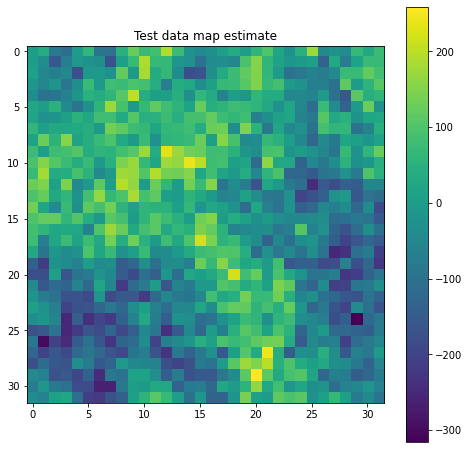

In [32]:
plt.figure(figsize=(8,8))
plt.imshow(s_hat_test)
plt.colorbar()
plt.title('Test data map estimate')

# 1.4 Testing

Check the result with test signal only and construct the map with D&S (14.33)

In [33]:
dt_signal = cmb_data['test_signal']

In [34]:
s_hat_test_signal = np.zeros((nx, ny), dtype=float)
m = np.zeros((nx, ny), dtype=float)
np.add.at(s_hat_test_signal, (x, y), dt_signal)
np.add.at(m, (x, y), 1)
s_hat_test_signal = s_hat_test_signal/m

Text(0.5, 1.0, 'Test signal-only map')

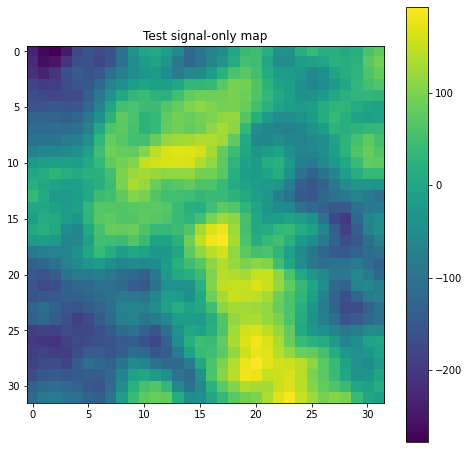

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(s_hat_test_signal)
plt.colorbar()
plt.title('Test signal-only map')

Text(0.5, 1.0, 'Noise in test data map estimate')

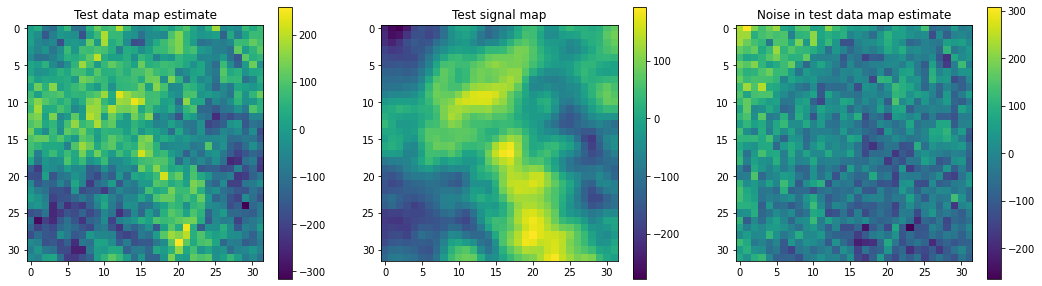

In [36]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(s_hat_test)
plt.colorbar()
plt.title('Test data map estimate')
plt.subplot(132)
plt.imshow(s_hat_test_signal)
plt.colorbar()
plt.title('Test signal map')
plt.subplot(133)
plt.imshow(s_hat_test - s_hat_test_signal)
plt.colorbar()
plt.title('Noise in test data map estimate')

# 2. Power Spectrum estimation

In this section, we are looking to estimate the band powers, $c^\alpha$

Applying Dodelson 1st edition eqn 11.94 in this context gives:
    
\begin{equation}
\hat{c^\alpha} = c^\alpha_{0} + F^{-1}_{\alpha \beta}\frac{s C^{-1} C_{,\beta} C^{-1} s - Tr(C^{-1} C_{,\beta})}{2}
\end{equation}

where 
\begin{equation}
F_{\alpha \beta} =  \frac{Tr(C_{, \alpha} C^{-1} C_{,\beta} C^{-1})}{2}
\end{equation}

\begin{equation}
C = C_{S} + C_{N}
\end{equation}

$s$ is our signal map created in the previous part, and $c^\alpha_{0}$ is calculated from a fiducial model, in our case, CAMB


We have already calculated $C_{N}$ in the previous part, we just need $C_{S}$, which enters into the equation for $\hat{c^\alpha}$ in two parts:

1. $C^{-1}$
2. $C_{,\alpha}$

## 2.1 Signal Covariance Matrix

To account for $C_{S}$ in the calculation of $C^{-1}$, we will use our fiducial cosmology to fix $C_{l}$ and apply:

\begin{equation}
C_{S}= \bar{T}^{2} \omega(\lvert \theta_{i} - \theta_{j} \rvert, \lambda_{\alpha})
\end{equation}

with 

\begin{equation}
\omega(\theta, \lambda_{\alpha}) = \int_{0}^{\infty} \frac{dl}{2\pi} C_{l}(\lambda_{\alpha})J_{0}(l\theta)
\end{equation}

In [37]:
Tbar = 2.725e6 # known value in microK 

# Get C_l from CAMB
pars = cmb_utils.fast_camb_settings() # Use this from what Kiyo gave us
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
totCL = powers['total']
ls = np.arange(totCL.shape[0])[1:] # get rid of l = 0
Cls_withfactors = totCL[:,0][1:] # this goes out to l = 1500 per the settings, and we get rid of l=0
Cls = Cls_withfactors / (ls * (ls + 1) * Tbar**2 / (2 * np.pi))

In [39]:
# calculate angular correlation function
theta_beam = 0.000667 # radians, as specified in pdf
max_theta = pix_width * np.linalg.norm([nx, ny])
sampled_thetas = np.linspace(0, max_theta, 300)
w_theta_data = np.array([trapz(jv(0, ls * theta) * Cls * np.exp(-ls**2 * theta_beam**2)) for theta in sampled_thetas])
w_theta = interp1d(sampled_thetas, w_theta_data)

In [61]:
# calculate theta values between all pixels 
thetas = np.zeros((nx,ny,nx,ny), dtype=float) # initalize array

# angle between pixel a = (ax, ay) and pixel b = (bx, by) stored at (ax, ay, bx, by)
# angle in radians is distance (in pixels) between pixels times pix_width
# FIXME: this below chunk seriously needs to be vectorized
for ax in range(thetas.shape[0]):
    for ay in range(thetas.shape[1]):
        for bx in range(thetas.shape[2]):
            for by in range(thetas.shape[3]):
                thetas[ax, ay, bx, by] = pix_width * np.sqrt(np.abs(bx - ax)**2 + np.abs(by - ay)**2)

thetas = thetas.flatten()
CS_test = Tbar**2 * w_theta(thetas)
CS_test = np.reshape(CS_test, (nx*ny,nx*ny))

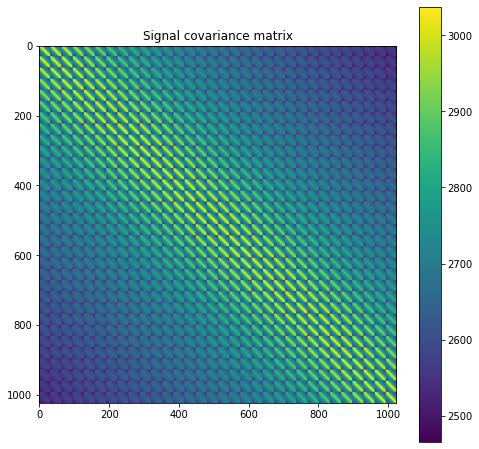

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(C_S)
plt.colorbar()
plt.title('Signal covariance matrix');

## 2.2 Band Powers

To account for $C_{S}$ in the calculation of $C_{,\alpha}$ we will use band powers $c^{\alpha}$  as our parameters:

\begin{equation}
C_{l}^{obs} \approx \sum_{\alpha}c^{\alpha}E_{\alpha}(l)
\end{equation}

where 
\begin{equation}
E_{\alpha}(l) = 
\begin{cases}  
1 & l_{\alpha}^{low} \leq l < l_{\alpha + 1}^{low} \\
0 & otherwise \\
\end{cases}
\end{equation}

It can then be shown that 
\begin{equation}
C_{,\alpha} = \int_{0}^{\infty} \frac{dl}{2\pi} E_{\alpha}(l)J_{0}(l\theta)
\end{equation}

In [87]:
# create logarithmically spaced l bins to use for bandpowers 
l_min = min(ls) 
l_max = pars.max_l # get from CAMB parameters
l_bin_edges = np.linspace(l_min, l_max, 31, endpoint=True) # 31 numbers for 30 bins,  for test data

In [89]:
# FIXME: working from top of this cell, unsure if the rest here is what we want
# FIXME: efficient way to find E_alpha might be an adaptation of cmb_utils.naieve_estimator
# eq 8 basically changes the bounds of integration for eq 9

# array to store C_ , alpha values


C_alphas = np.array([])
# for each alpha
for alpha in range(len(l_bin_edges) - 1):
    # integration only within bin
    
    ls_int = ls[ np.logical_and(ls > l_bin_edges[alpha],ls < l_bin_edges[alpha+1]) ]
    
    C_alpha_data = np.array([trapz(jv(0, ls_int*theta)) for theta in sampled_thetas])
    C_alpha_interp = interp1d(sampled_thetas, C_alpha_data)
    
    C_alphas = np.append(C_alphas, C_alpha_interp(thetas))

    
    # get the C_l value of the relevant modes that are within the l_bin
    # FIXME: this is not complete, copy and pasted from week 10
    #modes = np.array([mode[1] for mode in kmags_delta_gk if k_bins[alpha] < mode[0] and mode[0] < k_bins[alpha+1]])
    
C_alphas = np.reshape(C_alphas, (len(l_bin_edges) -1, nx*ny, nx*ny))

In [70]:
# now we can calculate our estimates for c hat alpha:

C_test = CS_test + CN_test 

C_alphas

array([-2.8317987 , -0.18998464,  0.10311399,  0.06879545, -0.04192471,
       -0.06323406,  0.01497622,  0.05676376,  0.00332551, -0.04865333,
       -0.01675087,  0.03900663,  0.02629735, -0.02826892, -0.03231207,
        0.01704062,  0.03501232, -0.00598054, -0.03465823, -0.00426207,
        0.03161247,  0.01310225, -0.02635085, -0.02006349,  0.01944679,
        0.02481116, -0.01154014, -0.02717386,  0.00329729])

# Parameter inference

In [42]:
import importlib
importlib.reload(cmb_utils)

<module 'cmb_utils' from '/Users/gmo/Google Drive/MIT/8.942/code/cmb-map-making/cmb_utils.py'>

In [43]:
# get test case from kiyo's estimator, with bins changed to 30 (instead of 50) for the smaller test data
test_Cl, test_n_modes, test_l_bin_edges = cmb_utils.naieve_PS_estimator(s_hat_test, pix_width)
# this doesn't seem to give us the fisher matrix, sadly

## 3.1 Least-squares
This is a non-linear least squares problem with
\begin{equation}
-2\ln\mathcal{L} + \mathrm{constant} = \chi^2(p_\gamma) = \sum_{\alpha \beta} [\hat{c}_\alpha - C^\mathrm{obs}_{l\alpha}(p_\gamma)]F_{\alpha \beta}[\hat{c}_\beta - C^\mathrm{obs}_{l\beta}(p_\gamma)],
\end{equation}
where $l_\alpha = (l_\alpha^{\mathrm{low}} + l_{\alpha+1}^{\mathrm{low}})/2$.

In [143]:
import fitters
# FIXME: fitters.py needs to be modified for this case

In [51]:
test_Cl

array([1.44358959, 0.1352707 , 0.10544357, 0.0333628 , 0.05001551,
       0.02847776, 0.0324765 , 0.01560578, 0.01235459, 0.01271612,
       0.00922351, 0.00680395, 0.0078838 , 0.00717857, 0.00710527,
       0.0106107 , 0.00837869, 0.00913907, 0.00598664, 0.00648007,
       0.00609454, 0.00537799, 0.0061754 , 0.00450925, 0.00678282,
       0.0042113 , 0.00317153, 0.00246724, 0.01596879])